<a href="https://colab.research.google.com/github/arjitkatare/Noise_GAN/blob/master/Copy_of_Copy_of_Copy_of_Rephrase_evaluation_version_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**File Download Script**


In [0]:
# # # # # # # # # # # ######Install files by uncommenting these######

# !wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip # uncomment it and run this if folder is not located in home directory
# !unzip -q pub*
# !pip install -U -q PyDrive
# # !pip install GPUtil




### **Mount Your Drive**

In [0]:
# ### No need to mount if you are only evaluating So skip this in that case ###

# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)




### *Trick*

In [0]:
###Trick##
#Allocate memory to a tensor and delete it just before your training starts
import torch

memory_holder = torch.zeros(200000,12000, device = 'cuda:0') #Loop hole for allocating gpu to us after restarting runtime faster :P
# memory_holder_2 = torch.zeros(200000,10000, device = 'cuda:0') #Loop hole for allocating gpu to us after restarting runtime faster :P
memory_holder_3 = torch.zeros(1,1, device = 'cuda:0') #Loop hole for allocating gpu to us after restarting runtime faster :P

# **Imports**

In [0]:
#%matplotlib inline
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

from torchvision import transforms, datasets
import torchvision.utils as vutils

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


import cv2
import numpy as np

## **Reset and Evaluation Control**

In [0]:
reset = False # Make sure this is False after you start training else your checkpoint is dead
Evaluation = False #Let it be off for now




### Set checkpoint name if Evaluating. Just download from the GOoogle Drive link mentioned above any checkpoint as per your convenience
checkpoint_name = 'v4.pt'
checkpoint_save_path = '/content/drive/My Drive/rephrase_weights_v2/{}'.format('v4.pt')

evaluation_checkpoint = None

if Evaluation == True:
  import os
  evaluation_checkpoint = './drive/My Drive/rephrase_weights_v2/{}'.format(checkpoint_name)
  if not os.path.exists('./drive'):
    os.makedirs('drive')
# Upload the downloaded file from google drive to this folder and update it's name here

  print('Evaluation is on and checkpoint path is now  is -->')
  print(evaluation_checkpoint)



# Continue

## **Checking Free Memory**

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi




# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()


## **Constants and Hyperparemeters**

In [0]:
ngpu = 1
batch_size = 16
i_size = 100
n_ch = 3
num_epochs = 25
n_iters = 100
n_fg = 25
n_fd = 256
lr = 0.0001
beta1 = 0.5
dropout_rate = 0.1
img_size_view = 25



## Only to be run Once

## **Given degrade function**

In [0]:
# # We will just use some part of it during implementing transforms while making dataloader function

# import cv2
# import numpy as np

# def degrade(input_path: str, output_path: str) -> None:
#         """Load image at `input_path`, distort and save as `output_path`"""
#         SHIFT = 1
#         image = cv2.imread(input_path)
#         image = cv2.resize(image, (i_size,i_size))
#         to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
#         swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
#         swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
#         image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
#         image[swap_indices] = swap_vals
#         cv2.imwrite(output_path, image)

# # #### Converting all distorted files in same manner as train ###

# def distort_folder_maker(name):
#   import os
#   rootdir = '/content/pubfig83lfw_raw_in_dirs/{}'.format(name)
#   distort_dir = '/content/pubfig83lfw_raw_in_dirs/{}_distort'.format(name)
#   train_count = 0

#   a = os.walk(rootdir)
#   _, dirs, _ = next(a)
#   for i in dirs:
#     if not os.path.exists(os.path.join(distort_dir,i)):
#       os.makedirs(os.path.join(distort_dir,i))


#   for subdir, dirs, files in os.walk(rootdir):
#       for file in files:
#         degrade(os.path.join(subdir, file), os.path.join(subdir.replace(name, '{}_distort'.format(name)), file) )


# distort_folder_maker('train')
# distort_folder_maker('test')        

In [0]:
# # We will just use some part of it during implementing transforms while making dataloader function

# import cv2
# import numpy as np

# def degrade2(input_path: str, output_path: str) -> None:
#         """Load image at `input_path`, distort and save as `output_path`"""
#         SHIFT = 1
#         image = cv2.imread(input_path)
#         image_copy = image.copy()
#         image = cv2.resize(image, (i_size,i_size))
#         to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
#         swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
#         swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
#         image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
#         image[swap_indices] = swap_vals
#         image = np.hstack((image,image_copy))
#         cv2.imwrite(output_path, image)

# # #### Converting all distorted files in same manner as train ###

# def distort_folder_maker(name):
#   import os
#   rootdir = '/content/pubfig83lfw_raw_in_dirs/{}'.format(name)
#   distort_dir = '/content/pubfig83lfw_raw_in_dirs/{}_distort'.format(name)
#   train_count = 0

#   a = os.walk(rootdir)
#   _, dirs, _ = next(a)
#   for i in dirs:
#     if not os.path.exists(os.path.join(distort_dir,i)):
#       os.makedirs(os.path.join(distort_dir,i))


#   for subdir, dirs, files in os.walk(rootdir):
#       for file in files:
#         degrade(os.path.join(subdir, file), os.path.join(subdir.replace(name, '{}_distort'.format(name)), file) )


# distort_folder_maker('train')
# distort_folder_maker('test')

In [0]:
# # #### Converting all distorted files in same manner as train ###

# def distort_folder_maker(name):
#   import os
#   rootdir = '/content/pubfig83lfw_raw_in_dirs/{}'.format(name)
#   distort_dir = '/content/pubfig83lfw_raw_in_dirs/{}_distort'.format(name)
#   train_count = 0

#   a = os.walk(rootdir)
#   _, dirs, _ = next(a)
#   for i in dirs:
#     if not os.path.exists(os.path.join(distort_dir,i)):
#       os.makedirs(os.path.join(distort_dir,i))


#   for subdir, dirs, files in os.walk(rootdir):
#       for file in files:
#         degrade(os.path.join(subdir, file), os.path.join(subdir.replace(name, '{}_distort'.format(name)), file) )


# distort_folder_maker('train')
# distort_folder_maker('test')


# **Main Code**

## **Setting Seed**

In [7]:
#Setting seed for reproducibility
random.seed(2)
torch.manual_seed(2)

## New function using degrade logic

In [0]:
def distortion(image):
  image = image.numpy()
  print(type(image), image.shape)
  SHIFT = 2
  to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
  swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
  swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
  image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
  image[swap_indices] = swap_vals
  # cv2_imshow(image)
  return torch.from_numpy(image)

## Data processing

In [0]:


def dataloader_loader(which_dataset, distort = False, shuffle = True):
  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(i_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5, 0.5, 0.5], #Normalizing as the values are in range [0,1] in given dataset
                               std=[0.25, 0.25, 0.25]), # some empirical changes for visiual quality check
      ])
  
  bb_size = batch_size
  
  if not shuffle:
    data_transform = transforms.Compose([
        transforms.Resize(i_size),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5, 0.5, 0.5], #Normalizing as the values are in range [0,1] in given dataset
                             std=[0.25, 0.25, 0.25]), # some empirical changes for visiual quality check
      ])
    bb_size = 8
    
  
  if distort:
    # data_transform = transforms.Compose([data_transform, transforms.Lambda(lambda img: distortion(img))])
    # data_transform = transforms.Compose([transforms.Lambda(lambda img: distortion(img)), data_transform])
    data_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Lambda(lambda img: distortion(img)),
          transforms.ToPILImage(),
          transforms.RandomSizedCrop(i_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          # transforms.Normalize(mean=[0.5, 0.5, 0.5], #Normalizing as the values are in range [0,1] in given dataset
          #                      std=[0.25, 0.25, 0.25]), # some empirical changes for visiual quality check
      ])
  root_dir = '/content/pubfig83lfw_raw_in_dirs/{}'.format(which_dataset)
  rephrase_dataset = datasets.ImageFolder(root=root_dir,
                                             transform=data_transform)
  return torch.utils.data.DataLoader(rephrase_dataset,
                                    batch_size= bb_size, shuffle=shuffle,
                                    num_workers=4)

In [10]:
# Counting number of files we have in our directory

import os
rootdir = '/content/pubfig83lfw_raw_in_dirs/train'

train_count = 0
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
      # print(os.path.join(subdir, file))
      pass

      train_count+=1
print(train_count)

8720


In [11]:
train_dataloader_real = dataloader_loader('train')
train_dataloader_fake = dataloader_loader('train_distort')
test_dataloader_fake = dataloader_loader('test_distort')
test_dataloader_real = dataloader_loader('test')
test_dataloader_fake_without_shuffle = dataloader_loader('test_distort',shuffle = False)
test_dataloader_real_without_shuffle = dataloader_loader('test', shuffle = False)

len(dataloader_loader('train'))

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:692: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


545

Length is less due to batching, dataloader stores number of files they have in total by default and after batching we get total number of possible batches

## Setting device to use for tensor operation

In [12]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = 'cpu' #gpu is full so using cpu as default
print('Using - ',device)

Using -  cuda:0


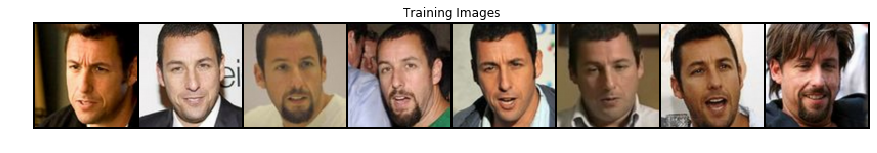

In [13]:
# Plot some training images
real_batch = next(iter(test_dataloader_real_without_shuffle))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


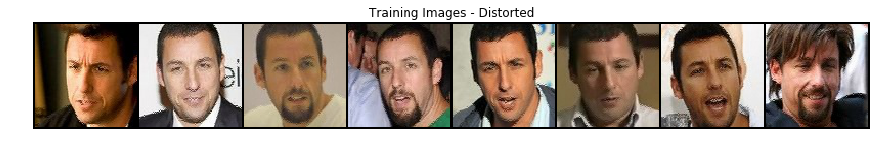

In [14]:
# Plot some training images
fake_batch = next(iter(test_dataloader_fake_without_shuffle))

plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images - Distorted")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


## Weight Init function for batchnorm and conv2d

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [0]:
# Generator Code

class Generator_v1(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg)
        self.conv2 = conv_relu_normalized(n_fg,n_fg*4)
        self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
        self.conv4 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
        self.conv6 = conv_relu_normalized(n_fg*4,n_fg)
        self.conv7 = conv_relu_normalized(n_fg,n_ch)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x

class Generator_v2(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg)
        self.conv2 = conv_relu_normalized(n_fg,n_fg*8)
#         self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
        self.conv4_1 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_2 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_3 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_4 = conv_relu_normalized(n_fg*8,n_fg*8)
#         self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
        self.conv6 = conv_relu_normalized(n_fg*8,n_fg)
        self.conv7 = nn.Conv2d(n_fg,n_ch,3, padding = 2, dilation = 2 )
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
#         x = self.conv3(x)
        
        x = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv4_2(x) + x
        x = self.conv4_3(x) + x
        x = self.conv4_4(x) + x
        
#         x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x



class Generator_v3(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg*4)
#         self.conv2 = conv_relu_normalized(n_fg,n_fg*8)
#         self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
        ### Dense Unit ### Only one is used as dense layers are quite heavy on GPU on Google Colab, still model is able to learn detail features
                          # Just add more dense layers in order to retain more features and you may get better result than shown here
        self.conv4_1 = conv_relu_normalized(n_fg*4,n_fg*8)
        self.conv4_2 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_3 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_4 = conv_relu_normalized(n_fg*8,n_fg*4)
#         self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
#         self.conv6 = conv_relu_normalized(n_fg*8,n_fg)
        self.conv7 = conv_relu_normalized(n_fg*4,n_ch)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
#         x = self.conv3(x)
        
        x = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv4_2(x) + x
        x = self.conv4_3(x) + x
        x = self.conv4_4(x)
        
#         x = self.conv5(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x
    
class Generator_v4(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
#         self.conv1 = conv_relu_normalized(n_ch,n_fg*8)
# #         self.conv2 = conv_relu_normalized(n_fg,n_fg*8)
# #         self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
#         ### Dense Unit ### Only one is used as dense layers are quite heavy on GPU on Google Colab, still model is able to learn detail features
#                           # Just add more dense layers in order to retain more features and you may get better result than shown here
#         self.conv4_1 = conv_relu_normalized(n_fg*8,n_fg*8)
#         self.conv4_2 = conv_relu_normalized(n_fg*8,n_fg*8)
#         self.conv4_3 = conv_relu_normalized(n_fg*8,n_fg*8)
#         self.conv4_4 = conv_relu_normalized(n_fg*8,n_fg*8)
# #         self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
# #         self.conv6 = conv_relu_normalized(n_fg*8,n_fg)
#         self.conv7 = conv_relu_normalized(n_fg*8,n_ch)
#                   self.tanh = nn.Tanh()
        
        self.conv1 = nn.Conv2d(n_ch,n_fg*2,3, padding = 2, dilation = 1 )
        self.batch1 = nn.BatchNorm2d(n_fg*2)
        self.relu1 = nn.LeakyReLU(True)
        self.downS = nn.Conv2d(n_fg*2,n_fg*4,3, padding = 2, dilation = 1, stride = 2 )
        
        self.conv2_1 = conv_relu_normalized(n_fg*4, n_fg*4)
        self.conv2_2 = conv_relu_normalized(n_fg*4, n_fg*4)
        self.conv2_3 = conv_relu_normalized(n_fg*4, n_fg*4)
        self.conv2_4 = conv_relu_normalized(n_fg*4, n_fg*4)

        self.upS = nn.ConvTranspose2d(n_fg*4,n_fg*2, 3, stride = 2 )

        self.conv3_1 = conv_relu_normalized(n_fg*2, n_fg*2)
        self.conv3_2 = conv_relu_normalized(n_fg*2, n_fg*2)
        self.conv3_3 = conv_relu_normalized(n_fg*2, n_fg*2)
        self.conv3_4 = conv_relu_normalized(n_fg*2, n_fg*2)

        self.convF = nn.Conv2d(n_fg*2, n_ch, 3, stride = 1, dilation = 1)
        self.tanh = nn.Tanh()

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.downS(x)

        x = self.conv2_1(x)
        x_2_1 = x
        x = self.conv2_2(x) + x
        x_2_2 = x
        x = self.conv2_3(x) + x + x_2_2
        x = self.conv2_4(x) + x + x_2_2 + x_2_1

        x = self.upS(x)

        x = self.conv3_1(x)
        x_3_1 = x
        x = self.conv3_2(x) + x
        x_3_2 = x
        x = self.conv3_3(x) + x + x_3_2
        x = self.conv3_4(x) + x + x_3_2 + x_3_1

        x = self.convF(x)
        x = self.tanh(x)

        
        
        return x


class Generator_v5(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg*2)
#         self.conv2 = conv_relu_normalized(n_fg,n_fg*8)
        self.conv3 = conv_relu_normalized(n_fg*2,n_fg*2)
        ### Dense Unit ### Only one is used as dense layers are quite heavy on GPU on Google Colab, still model is able to learn detail features
                          # Just add more dense layers in order to retain more features and you may get better result than shown here
        self.conv4_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv4_2 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv4_3 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv4_4 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv5 = conv_relu_normalized(n_fg*2,n_fg*2)
        # self.conv6 = conv_relu_normalized(n_fg*8,n_fg*4)
        self.conv7 = conv_relu_normalized(n_fg*2,n_ch)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv3(x)
        
        x = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv4_2(x) + x
        x = self.conv4_3(x) + x
        x = self.conv4_4(x) + x
        
        x = self.conv5(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x

class Generator_v6(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg*2)

        # self.conv2 = conv_relu_normalized(n_fg*2,n_fg*2)
        ### Dense Unit ### Only one is used as dense layers are quite heavy on GPU on Google Colab, still model is able to learn detail features
                          # Just add more dense layers in order to retain more features and you may get better result than shown here
        self.conv2_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv2_2 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv2_3 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv2_4 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv3 = conv_relu_normalized(n_fg*2,n_fg*4)

        # self.conv5 = conv_relu_normalized(n_fg*2,n_fg * 4)

        self.conv4_1 = conv_relu_normalized(n_fg*4,n_fg*4)
        self.conv4_2 = conv_relu_normalized(n_fg*4,n_fg*4)
        self.conv4_3 = conv_relu_normalized(n_fg*4,n_fg*4)
        self.conv4_4 = conv_relu_normalized(n_fg*4,n_fg*4)
        self.conv5 = conv_relu_normalized(n_fg*4,n_fg*2)

        self.conv6_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv6_2 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv6_3 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv6_4 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv7 = conv_relu_normalized(n_fg*2,n_fg)

        self.conv8 = conv_relu_normalized(n_fg,n_ch)


        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.conv2_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv2_2(x) + x
        x = self.conv2_3(x) + x
        x = self.conv2_4(x) + x
        
        x = self.conv3(x)
        x = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv4_2(x) + x
        x = self.conv4_3(x) + x
        x = self.conv4_4(x) + x

        x = self.conv5(x)

        x = self.conv6_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv6_2(x) + x
        x = self.conv6_3(x) + x
        x = self.conv6_4(x) + x

        x = self.conv7(x)

        x = self.conv8(x)

        x = self.tanh(x)
        
        return x     


class Generator_v7(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
#         class GroupNorm(nn.Module):
#           def __init__(self, num_features, num_groups=32, eps=1e-5):
#               super(GroupNorm, self).__init__()
#               self.weight = nn.Parameter(torch.ones(1,num_features,1,1))
#               self.bias = nn.Parameter(torch.zeros(1,num_features,1,1))
#               self.num_groups = num_groups
#               self.eps = eps

#           def forward(self, x):
#               N,C,H,W = x.size()
#               G = self.num_groups
#               assert C % G == 0

#               x = x.view(N,G,-1)
#               mean = x.mean(-1, keepdim=True)
#               var = x.var(-1, keepdim=True)

#               x = (x-mean) / (var+self.eps).sqrt()
#               x = x.view(N,C,H,W)
#               return x * self.weight + self.bias
        
        class depthwise_separable_conv(nn.Module): # speed_boost -> This helps in reducing number of multiplication in CNN by a really high margin  while making dense filters
          def __init__(self, nin, nout):
              super(depthwise_separable_conv, self).__init__()
              self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
              self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

          def forward(self, x):
              out = self.depthwise(x)
              out = self.pointwise(out)
              return out

        def conv_relu_normalized(inp,out):
          return nn.Sequential(depthwise_separable_conv(inp,out), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg*2)

        # self.conv2 = conv_relu_normalized(n_fg*2,n_fg*2)
        ### Dense Unit ### Only one is used as dense layers are quite heavy on GPU on Google Colab, still model is able to learn detail features
                          # Just add more dense layers in order to retain more features and you may get better result than shown here
        self.conv2_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv2_2 = conv_relu_normalized(n_fg*4,n_fg*2)
        self.conv2_3 = conv_relu_normalized(n_fg*6,n_fg*2)

        self.conv3 = conv_relu_normalized(n_fg*8,n_fg*2)



        self.conv4_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv4_2 = conv_relu_normalized(n_fg*4,n_fg*2)
        self.conv4_3 = conv_relu_normalized(n_fg*6,n_fg*2)
        
        self.conv5 = conv_relu_normalized(n_fg*8,n_fg*2)

        self.conv6_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv6_2 = conv_relu_normalized(n_fg*4,n_fg*2)
        self.conv6_3 = conv_relu_normalized(n_fg*6,n_fg*2)
        

        self.conv7 = conv_relu_normalized(n_fg*8,n_fg)
        self.conv8 = conv_relu_normalized(n_fg,n_ch)


        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        
        conv2_1 = self.conv2_1(x) #DenseNet for better gradient flow back to the generator as per state of the art paper
        x = torch.cat([x,conv2_1], 1)
        conv2_2 = self.conv2_2(x) + conv2_1
        x = torch.cat([x,conv2_2], 1) 
        conv2_3 = self.conv2_3(x) + conv2_2 + conv2_1
        x = torch.cat([x,conv2_3], 1)
        x = self.conv3(x) #transisiton -> this can be used to decrease or increase the size(up-down sampling)

        conv4_1 = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = torch.cat([x,conv4_1], 1)
        conv4_2 = self.conv4_2(x) + conv4_1
        x = torch.cat([x,conv4_2], 1) 
        conv4_3 = self.conv4_3(x) + conv4_2 + conv4_1
        x = torch.cat([x,conv4_3], 1)
        x = self.conv5(x) #transisiton -> this can be used to decrease or increase the size(up-down sampling)

        conv6_1 = self.conv6_1(x) #DenseNet for better gradient flow back to the generator
        x = torch.cat([x,conv6_1], 1)
        conv6_2 = self.conv6_2(x) + conv6_1
        x = torch.cat([x,conv6_2], 1) 
        conv6_3 = self.conv6_3(x) + conv6_2 + conv6_1
        x = torch.cat([x,conv6_3], 1)
        x = self.conv7(x) #transisiton -> this can be used to decrease or increase the size(up-down sampling)

        x = self.conv8(x)

        x = self.tanh(x)
        
        return x             

class Generator_v8(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        class GroupNorm(nn.Module):
          def __init__(self, num_features, num_groups=32, eps=1e-5):
              super(GroupNorm, self).__init__()
              self.weight = nn.Parameter(torch.ones(1,num_features,1,1))
              self.bias = nn.Parameter(torch.zeros(1,num_features,1,1))
              self.num_groups = num_groups
              self.eps = eps

          def forward(self, x):
              N,C,H,W = x.size()
              G = self.num_groups
              assert C % G == 0

              x = x.view(N,G,-1)
              mean = x.mean(-1, keepdim=True)
              var = x.var(-1, keepdim=True)

              x = (x-mean) / (var+self.eps).sqrt()
              x = x.view(N,C,H,W)
              return x * self.weight + self.bias
        
        class depthwise_separable_conv(nn.Module): # speed_boost -> This helps in reducing number of multiplication in CNN by a really high margin  while making dense filters
          def __init__(self, nin, nout):
              super(depthwise_separable_conv, self).__init__()
              self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
              self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

          def forward(self, x):
              out = self.depthwise(x)
              out = self.pointwise(out)
              return out

        def conv_relu_normalized(inp,out):
          return nn.Sequential(depthwise_separable_conv(inp,out), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          GroupNorm(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg*2)

        # self.conv2 = conv_relu_normalized(n_fg*2,n_fg*2)
        ### Dense Unit ### Only one is used as dense layers are quite heavy on GPU on Google Colab, still model is able to learn detail features
                          # Just add more dense layers in order to retain more features and you may get better result than shown here
        self.conv2_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv2_2 = conv_relu_normalized(n_fg*4,n_fg*2)
        self.conv2_3 = conv_relu_normalized(n_fg*6,n_fg*2)

        self.conv3 = conv_relu_normalized(n_fg*8,n_fg*2)



        self.conv4_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv4_2 = conv_relu_normalized(n_fg*4,n_fg*2)
        self.conv4_3 = conv_relu_normalized(n_fg*6,n_fg*2)
        
        self.conv5 = conv_relu_normalized(n_fg*8,n_fg*2)

        self.conv6_1 = conv_relu_normalized(n_fg*2,n_fg*2)
        self.conv6_2 = conv_relu_normalized(n_fg*4,n_fg*2)
        self.conv6_3 = conv_relu_normalized(n_fg*6,n_fg*2)
        

        self.conv7 = conv_relu_normalized(n_fg*8,n_fg)
        self.conv8 = conv_relu_normalized(n_fg,n_ch)


        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        
        conv2_1 = self.conv2_1(x) #DenseNet for better gradient flow back to the generator as per state of the art paper
        x = torch.cat([x,conv2_1], 1)
        conv2_2 = self.conv2_2(x) + conv2_1
        x = torch.cat([x,conv2_2], 1) 
        conv2_3 = self.conv2_3(x) + conv2_2 + conv2_1
        x = torch.cat([x,conv2_3], 1)
        x = self.conv3(x) #transisiton -> this can be used to decrease or increase the size(up-down sampling)

        conv4_1 = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = torch.cat([x,conv4_1], 1)
        conv4_2 = self.conv4_2(x) + conv4_1
        x = torch.cat([x,conv4_2], 1) 
        conv4_3 = self.conv4_3(x) + conv4_2 + conv4_1
        x = torch.cat([x,conv4_3], 1)
        x = self.conv5(x) #transisiton -> this can be used to decrease or increase the size(up-down sampling)

        conv6_1 = self.conv6_1(x) #DenseNet for better gradient flow back to the generator
        x = torch.cat([x,conv6_1], 1)
        conv6_2 = self.conv6_2(x) + conv6_1
        x = torch.cat([x,conv6_2], 1) 
        conv6_3 = self.conv6_3(x) + conv6_2 + conv6_1
        x = torch.cat([x,conv6_3], 1)
        x = self.conv7(x) #transisiton -> this can be used to decrease or increase the size(up-down sampling)

        x = self.conv8(x)

        x = self.tanh(x)
        
        return x             
              

## Generator Graph

In [17]:
# Create the generator
netG = Generator_v7(ngpu).to(device)
netG.apply(weights_init)


print(netG)

try:
  del(memory_holder_2)
except:
  pass

Generator_v7(
  (conv1): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (pointwise): Conv2d(3, 50, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): LeakyReLU(negative_slope=True)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_1): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=50)
      (pointwise): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): LeakyReLU(negative_slope=True)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_2): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=100)
      (pointwise): Conv2d(100, 50, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): LeakyReLU(negative_s

## Output size assertion of generator

In [0]:
fake_value = next(iter(train_dataloader_fake))

# assert fake_value[0][0:1].to(device).shape == netG(fake_value[0][0:1].to(device)).shape



In [19]:

len(fake_value[0][0:1]),netG(fake_value[0][0:1].to(device)).shape


(1, torch.Size([1, 3, 100, 100]))

## Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(n_ch, n_fd , 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),

            nn.Conv2d(n_fd, n_fd * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),

            nn.Conv2d(n_fd * 2, n_fd * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),

            nn.Conv2d(n_fd * 4, n_fd * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),

            nn.Conv2d(n_fd * 8, 1, 4, 1, 0, bias=False),
            
        )
        self.fc1 = nn.Linear(9,1)
        self.sigmoid = nn.Sigmoid()
        
        self.check = True
    def forward(self, x):
      
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x_len = x.size(1) 
#         if self.check :
#           self.check = False
#           print(x_len)
#           self.fc1 = nn.Linear(x_len,1)
#           print(self.fc1)
        
        x = self.fc1(x)

        
        x = self.sigmoid(x)
        return x
        
class Discriminator_v2(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 , bias = False), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
        
        
        self.main = nn.Sequential(
            conv_relu_normalized(n_ch, n_fd),
            
#             nn.Conv2d(n_ch, n_fd , 4, 1, 1, bias=False),

#             nn.LeakyReLU(0.2, inplace=True),
#             nn.BatchNorm2d(n_fd),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),
            
            
            conv_relu_normalized(n_fd, n_fd * 2),
#             nn.Conv2d(n_fd, n_fd * 2, 4, 1, 1, bias=False),
            
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.BatchNorm2d(n_fd * 2),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),
            
            
            conv_relu_normalized(n_fd * 2, n_fd * 4),
#             nn.Conv2d(n_fd * 2, n_fd * 4, 4, 1, 1, bias=False),
            
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.BatchNorm2d(n_fd * 4),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),
            
            
            conv_relu_normalized(n_fd * 4, n_fd * 8),
#             nn.Conv2d(n_fd * 4, n_fd * 8, 4, 1, 1, bias=False),
            
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.BatchNorm2d(n_fd * 8),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            nn.Conv2d(n_fd * 8, 1, 4, 1, 0, bias=False),
            
        )
        self.fc1 = nn.Linear(9,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x_len = x.size(1) 
        
        x = self.fc1(x)
#         print(1)
        
        x = self.sigmoid(x)
        return x
        

In [21]:
# Create the Discriminator
netD = Discriminator_v2(ngpu).to(device)
netD.apply(weights_init)

print(netD)

Discriminator_v2(
  (main): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1)
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=True)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1)
    (6): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=True)
      (2): BatchNorm2d(1024, eps=1e-

## Output test for discriminator

In [22]:
real_value = next(iter(train_dataloader_real))
type(real_value)

list

In [23]:
print(len(netD(real_value[0][0:5].to(device)).view(-1)))
netD(real_value[0][0:1].to(device)).view(-1)

5


tensor([0.0294], device='cuda:0', grad_fn=<ViewBackward>)

## Setting up loss function and optimiser

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Checking D

In [25]:

if Evaluation == False:
  checkpoint_path = 'drive/My Drive/rephrase_weights_v2'

  if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

  if len(os.listdir(checkpoint_path) ) == 0:
      checkpoint_load = False
  else:    
      checkpoint_load = True


  checkpoint_path = checkpoint_path + '/v4.pt'

  print(checkpoint_path)


drive/My Drive/rephrase_weights_v2/v4.pt


## Pre-Training tasks


In [0]:
reset = False

if reset == True:
  checkpoint_load = False
  print(' reset is True and checkpoints will be reinitialised')
else:
  checkpoint_load = True

# Training

In [0]:
# Training Loop

##### Play wit these accordingly to check how your GAN is mapping out the noise pattern ########
#Some training constants to keep check from a single place
GENERATOR_FORCING = 1 #how many extra time you want to train your Generator --> Playing with this is still easy
turn_off_discriminator_training = False # Don't do it .... Bad Idea for now
DISCRIMINATOR_FORCING = 2 # Not yet used so no need to change this
### Okay don't play much, this is just for curiosity and hypothesis checking and may make your model go totally wrong ###

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
start_epoch = 0
fixed_noise = next(iter(train_dataloader_fake))
test_dataloader_fake_iter = iter(test_dataloader_fake)




if Evaluation == True:
  print('Checkpoint found')
  print(evaluation_checkpoint)
  state = torch.load(evaluation_checkpoint)
  netG.load_state_dict(state['generator_state'])
  netD.load_state_dict(state['discriminator_state'])
  iters = state['iters']
  img_list = state['img_list']
  G_losses = state['G_losses']
  D_losses = state['D_losses']
  start_epoch = state['epoch']
  print('Checkpoint loaded')
  print('Epochs - ', start_epoch)
  print('iters - ', iters)
elif checkpoint_load == True:
  print('Checkpoint found')
  state = torch.load(checkpoint_path)
  netG.load_state_dict(state['generator_state'])
  netD.load_state_dict(state['discriminator_state'])
  optimizerD.load_state_dict(state['discriminator optimizer'])
  optimizerG.load_state_dict(state['generator_optimizer'])
  iters = state['iters']
  img_list = state['img_list']
  G_losses = state['G_losses']
  D_losses = state['D_losses']
  start_epoch = state['epoch']
  fixed_noise = state['fixed_noise']
  print('Checkpoint loaded')
  print('Epochs - ', start_epoch)
  print('iters - ', iters)
else:
  netG.apply(weights_init)
  netD.apply(weights_init)
  

#Here we have assumed that real and fake are analogous to normal and distorted images

######## Important part #######
#Setting both in train mode initially
netG.train()
netD.train()

if Evaluation == False:

  print("Starting Training Loop...")
# For each epoch
try:
  del(memory_holder)
except:
  pass

for epoch in range(start_epoch,num_epochs):
#   break
  if Evaluation == True:
    break
    
  # fixed_noise = next(iter(train_dataloader_fake))
  #     fixed_data_for_validation =  
  # For each batch in the dataloader
  noise_iter = iter(train_dataloader_fake)
  for i, data in enumerate(train_dataloader_real, 0):
    

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################

      ## I need to check whether to keep one during evaluation mode if we are training
#       netG.eval()
#       netD.train()

      ## Train with all-real batch
      netD.zero_grad()

      # Format batch
      real_data = data[0].to(device)
      del(data)
      b_size = real_data.size(0)
      label = torch.full((b_size,), real_label, device=device)

      # Forward pass real batch through D
      output = netD(real_data).view(-1)


      # Calculate loss on all-real batch
      errD_real = criterion(output, label)

      # Calculate gradients for D in backward pass
      errD_real.backward()
      D_x = output.mean().item()

      ## Train with all-fake batch
      # Generate batch of latent vectors

      noise = next(noise_iter)


      # Generate fake image batch with G
      fake = netG(noise[0].to(device))
      del(noise)
      label.fill_(fake_label) # resuing the same label again. just to save memory

      # Classify all fake batch with D
      output = netD(fake.detach()).view(-1)

      # Calculate D's loss on the all-fake batch
      try:
        errD_fake = criterion(output, label)
      except:
        continue

      # Calculate the gradients for this batch
      errD_fake.backward()
      D_G_z1 = output.mean().item()

      # Add the gradients from the all-real and all-fake batches
      errD = errD_real + errD_fake

      # Update D
      if not turn_off_discriminator_training:
        optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################

#       netG.train()
#       netD.eval()

      generator_forcing = GENERATOR_FORCING
      label.fill_(real_label)  # fake labels are real for generator cost

      for _ in range(generator_forcing):
        netG.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward(retain_graph = True)
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()


      # Output training stats
      if i % 10 == 0:
          with torch.no_grad():
              fake = netG(fixed_noise[0].to(device)).detach().cpu()

              fake_validate = netG(next(test_dataloader_fake_iter)[0].to(device))
              output = netD(fake_validate.detach()).view(-1)
              D_G_z1_validate = output.mean().item()
              
          print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tD(G(z))val: %.4f'
                % (epoch, num_epochs, i, len(train_dataloader_real),
                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, D_G_z1_validate))
          

          if i%50 == 0:
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

          state = {
              'discriminator_state': netD.state_dict(),
              'generator_state': netG.state_dict(),
              'discriminator optimizer':optimizerD.state_dict(),
              'generator_optimizer':optimizerG.state_dict(),
              'iters': iters,
              'epoch': epoch,
              'img_list':img_list,
              'G_losses': G_losses,
              'D_losses': D_losses,
              'fixed_noise': fixed_noise,
          }

          state2 = {
              'discriminator_state': netD.state_dict(),
              'generator_state': netG.state_dict(),
              'discriminator optimizer':optimizerD.state_dict(),
              'generator_optimizer':optimizerG.state_dict(),
              'iters': iters,
              'epoch': epoch,
              'img_list':img_list,
              'G_losses': G_losses,
              'D_losses': D_losses,
          }
#           if i%200 == 0:
#             torch.save(state,checkpoint_path.split('.')[0] + str(iters) + '.pt')
          torch.save(state2,'/content/drive/My Drive/rephrase_weights_v4/v3.pt')
#           if i%200 == 0:
#             torch.save(state,checkpoint_path.split('.')[0] + str(iters) + '.pt')
          torch.save(state,checkpoint_save_path)
          
          if reset == True:
            print('models state with variables saved\n\n') 

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())

      # Check how the generator is doing by saving G's output on fixed_noise
#       if (iters % 25 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader_real)-1)):
#           with torch.no_grad():
#               fake = netG(fixed_noise[0].to(device)).detach().cpu()
#           img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
#           state['img_list'] = img_list
#           torch.save(state,checkpoint_path+str(iters))

      iters += 1
      
      if i == 120:
        break


Checkpoint found
Checkpoint loaded
Epochs -  19
iters -  2889
Starting Training Loop...
[19/25][0/545]	Loss_D: 0.0143	Loss_G: 4.0279	D(x): 0.9979	D(G(z)): 0.0118 / 0.1072	D(G(z))val: 0.0634
[19/25][10/545]	Loss_D: 0.1673	Loss_G: 3.0242	D(x): 0.9094	D(G(z)): 0.0259 / 0.1863	D(G(z))val: 0.3689
[19/25][20/545]	Loss_D: 1.0081	Loss_G: 10.7762	D(x): 0.9777	D(G(z)): 0.4738 / 0.0002	D(G(z))val: 0.0166
[19/25][30/545]	Loss_D: 0.6905	Loss_G: 2.4274	D(x): 0.8783	D(G(z)): 0.2377 / 0.2010	D(G(z))val: 0.2349
[19/25][40/545]	Loss_D: 0.1432	Loss_G: 3.1565	D(x): 0.9125	D(G(z)): 0.0395 / 0.1151	D(G(z))val: 0.1129


## Setting model for evaluation

In [0]:
netG.eval()
netD.eval()

# netG.train()
# netD.train()



In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluating on Test Dataset

In [0]:
temp_iter_fake = iter(test_dataloader_fake_without_shuffle)
temp_iter_real = iter(test_dataloader_real_without_shuffle)




In [0]:
real = next(temp_iter_real)
fixed_noise = next(temp_iter_fake)
with torch.no_grad():
  fake_cleared = netG(fixed_noise[0].to(device)).detach().cpu()

with torch.no_grad():
  fake = (fixed_noise[0].to(device)).detach().cpu()
  real = (real[0].to(device)).detach().cpu()

net_images = (torch.cat(( real,fake)))

# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("real and distorted")
plt.imshow(np.transpose(vutils.make_grid(net_images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("Processed")
plt.imshow(np.transpose(vutils.make_grid(fake_cleared.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
real = next(temp_iter_real)
fixed_noise = next(temp_iter_fake)
with torch.no_grad():
  fake_cleared = netG(fixed_noise[0].to(device)).detach().cpu()

with torch.no_grad():
  fake = (fixed_noise[0].to(device)).detach().cpu()
  real = (real[0].to(device)).detach().cpu()

net_images = (torch.cat(( real,fake)))

# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("real and distorted")
plt.imshow(np.transpose(vutils.make_grid(net_images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("Processed")
plt.imshow(np.transpose(vutils.make_grid(fake_cleared.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
real = next(temp_iter_real)
fixed_noise = next(temp_iter_fake)
with torch.no_grad():
  fake_cleared = netG(fixed_noise[0].to(device)).detach().cpu()

with torch.no_grad():
  fake = (fixed_noise[0].to(device)).detach().cpu()
  real = (real[0].to(device)).detach().cpu()

net_images = (torch.cat(( real,fake)))

# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("real and distorted")
plt.imshow(np.transpose(vutils.make_grid(net_images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("Processed")
plt.imshow(np.transpose(vutils.make_grid(fake_cleared.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
real = next(temp_iter_real)
fixed_noise = next(temp_iter_fake)
with torch.no_grad():
  fake_cleared = netG(fixed_noise[0].to(device)).detach().cpu()

with torch.no_grad():
  fake = (fixed_noise[0].to(device)).detach().cpu()
  real = (real[0].to(device)).detach().cpu()

net_images = (torch.cat(( real,fake)))

# Plot some real images
plt.figure(figsize=(25,25))
plt.axis("off")
plt.title("real and distorted")
plt.imshow(np.transpose(vutils.make_grid(real.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# Plot some training images
plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
plt.title("Processed")
plt.imshow(np.transpose(vutils.make_grid(fake_cleared.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
#%%capture
fig = plt.figure(figsize=(img_size_view,img_size_view))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
state = {
              'discriminator_state': netD.state_dict(),
              'generator_state': netG.state_dict(),
              'discriminator optimizer':optimizerD.state_dict(),
              'generator_optimizer':optimizerG.state_dict(),
              'iters': iters,
              'epoch': epoch,
              'img_list':img_list,
              'G_losses': G_losses,
              'D_losses': D_losses,
          }
#           if i%200 == 0:
#             torch.save(state,checkpoint_path.split('.')[0] + str(iters) + '.pt')
torch.save(state,'/content/drive/My Drive/rephrase_weights_v4/v4.pt')